In [1]:
import os
import sys
# os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')
import jax
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
numpyro.enable_x64()
from gwb.omega_gw_jax import OmegaGWjax
from interpolation.spline import Spline
from inference.numpyro_model import model
from inference.numpyro_infer import NumpyroInference
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


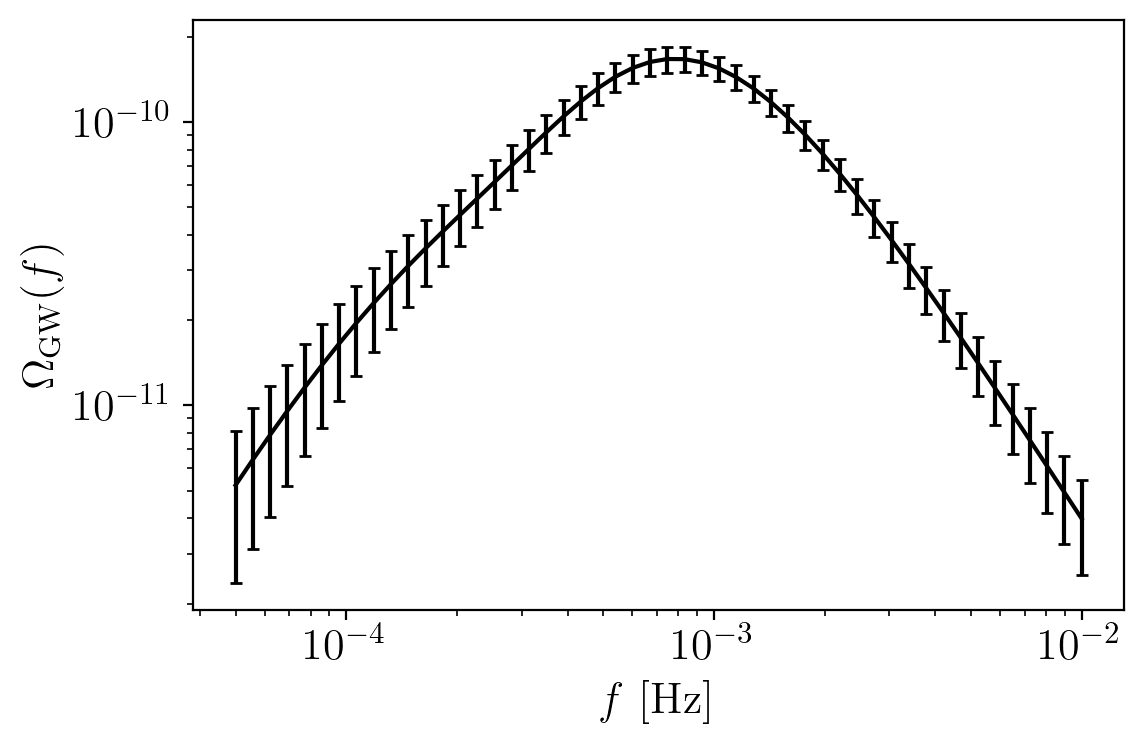

In [2]:
# load the gwb data from file and plot it
data = np.load('../bpl_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']
p_arr = data['p_arr']
pz_amp = data['pz_amp']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

#### Nautilus fixed nodes

In [5]:
s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 250)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

gwb_calculator = OmegaGWjax(s=s,t=t,f=frequencies,norm="RD",jit=True)

num_nodes = 4
free_nodes = num_nodes - 2
pk_min, pk_max = min(p_arr), max(p_arr)
left_node, right_node = np.log10(pk_min), np.log10(pk_max)
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)
y_max = -6
y_min = -2

def prior_1D(cube):
    # Order and transform nodes to be in the correct range, from Polychord SortedUniformPrior
    # params = np.atleast_2d(cube.copy())
    params = cube.copy()
    x = params[:free_nodes]
    # x = params[:,:free_nodes]
    # Npoints = cube.shape[0]
    N = free_nodes
    t = np.zeros(N)
    t[N-1] = x[N-1]**(1./N)
    for n in range(N-2, -1, -1):
        t[n] = x[n]**(1./(n+1)) * t[n+1]
    xs = t*(right_node - left_node) + left_node
    ys = params[free_nodes:]
    ys = ys*(y_max - y_min) + y_min
    return np.concatenate([xs,ys]) # array

def prior(cube):
    """
    Transforms the input cube from [0,1] uniform parameters to the desired prior space.
    This vectorized version supports cube being either a 1D array of shape (nd,)
    or a 2D array of shape (Npoints, nd).
    
    The cube is assumed to be structured as follows:
      - The first 'free_nodes' values correspond to the x parameters.
      - The remaining values correspond to the y parameters.
    
    Global variables used:
      free_nodes: int, number of nodes for the x parameters (also called N)
      left_node, right_node: floats defining the transformation range for x.
      y_min, y_max: floats defining the transformation range for y.
    """
    # Ensure cube is at least 2D (1D arrays are treated as a single row)
    cube = np.atleast_2d(cube.copy())
    
    N = free_nodes  # Number of x parameters
    # Extract x parameters (shape: (Npoints, free_nodes))
    x = cube[:, :N]
    
    # Create an array of exponents: 1/(1), 1/(2), ..., 1/(N)
    exponents = 1.0 / np.arange(1, N+1)
    # Raise x to the corresponding exponents, broadcasting over the rows
    # This gives an array 'y' of shape (Npoints, free_nodes)
    y = x ** exponents
    
    # Compute the reverse cumulative product along the second axis.
    # Step 1: Reverse the order of columns.
    # Step 2: Compute cumulative product along axis=1.
    # Step 3: Reverse the result back.
    t = np.cumprod(y[:, ::-1], axis=1)[:, ::-1]
    
    # Transform the cumulative product to the desired x space.
    xs = t * (right_node - left_node) + left_node
    
    # Process the y parameters (the remaining columns)
    ys = cube[:, N:]
    ys = ys * (y_max - y_min) + y_min
    
    # Concatenate the transformed x and y parameters along the second axis.
    return np.concatenate([xs, ys], axis=1)

from interpax import CubicSpline
from functools import partial
# from jax import lax

# def check_bounds(x):
#     # if x out of bounds return 0
#     lax.cond()

# @jit
def interpolate(nodes,vals,x):
    # nodes = jnp.pad(nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    spl = CubicSpline(nodes,vals,check=False)
    res = jnp.power(10,spl(x))
    res = jnp.where(x<left_node, 0, res)
    res = jnp.where(x>right_node, 0, res)
    return res

def get_gwb(nodes,vals):
    pf = lambda k: interpolate(nodes,vals,jnp.log10(k))
    omegagw = gwb_calculator(pf,frequencies)
    return (omegagw,)

get_gwb_func = jax.jit(get_gwb)

from utils import split_vmap

def likelihood(params):
    # print(params)
    params = jnp.atleast_2d(params)
    nodes = params[:,:free_nodes]
    # print(nodes)
    nodes = jnp.pad(nodes, ((0,0),(1,1)), 'constant', constant_values=((0,0),(left_node, right_node)))
    # print(nodes)
    vals = params[:,free_nodes:]
    omegagw = split_vmap(get_gwb_func,(nodes,vals))[0]
    # pf = lambda x: interpolate(nodes,vals,jnp.log10(x))
    # omegagw = gwb_calculator(pf,frequencies)
    # print(omegagw.shape)
    diff = omegagw - Omegas
    sol = np.linalg.solve(cov, diff.T).T
    res = -0.5 * np.sum(diff * sol, axis=1)
    # res = -0.5 * np.dot(diff, np.linalg.solve(cov,diff))
    res = np.where(np.isnan(res),-1e10, res)
    res = np.where(res<-1e10,-1e10, res)
    return res

import ultranest

param_names = [f'x{i}' for i in range(free_nodes)] + [f'y{i}' for i in range(num_nodes)]

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood, prior, log_dir="bpl_unest", resume=True,vectorized=True)
sampler.run(dlogz=0.1,show_status=False,log_interval=100)
sampler.print_results()
# sampler.run(verbose=True,f_live=0.1)
# print('log Z: {:.2f}'.format(sampler.log_z))

DEBUG:ultranest:ReactiveNestedSampler: dims=6+0, resume=True, log_dir=bpl_unest, backend=hdf5, vectorized=True, nbootstraps=30, ndraw=128..65536
DEBUG:ultranest:Testing resume consistency: [-7.58928822e+02 -7.54382607e+02  0.00000000e+00  3.94492655e-01
  8.26355329e-01  2.57718699e-01  2.41763849e-01  4.20050720e-01
  4.89682967e-01 -3.75863784e+00 -1.39121789e+00 -3.03087480e+00
 -2.96705539e+00 -3.68020288e+00 -3.95873187e+00]: u=[0.39449266 0.82635533 0.2577187  0.24176385 0.42005072 0.48968297] -> p=[-3.75863784 -1.39121789 -3.0308748  -2.96705539 -3.68020288 -3.95873187] -> L=-754.3826070493944 


[ultranest] Resuming from 2232 stored points


INFO:ultranest:Resuming from 2232 stored points
DEBUG:ultranest:Found plateau of 108/400 initial points at L=-1e+10. Avoid this by a continuously increasing loglikelihood towards good regions.


[ultranest] Widening roots to 507 live points (have 400 already) ...


INFO:ultranest:Widening roots to 507 live points (have 400 already) ...
DEBUG:ultranest:Found plateau of 139/507 initial points at L=-1e+10. Avoid this by a continuously increasing loglikelihood towards good regions.


[ultranest] Widening roots to 645 live points (have 507 already) ...


INFO:ultranest:Widening roots to 645 live points (have 507 already) ...
DEBUG:ultranest:run_iter dlogz=0.1, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.000000e+10, not replacing live point.
DEBUG:

DEBUG:ultranest:iteration=245, ncalls=20164, regioncalls=0, ndraw=128, logz=-448305.83, remainder_fraction=100.0000%, Lmin=-433726.36, Lmax=-333.85
DEBUG:ultranest:iteration=300, ncalls=20164, regioncalls=0, ndraw=128, logz=-31606.65, remainder_fraction=100.0000%, Lmin=-29509.28, Lmax=-333.85
DEBUG:ultranest:iteration=335, ncalls=20164, regioncalls=0, ndraw=128, logz=-4721.40, remainder_fraction=100.0000%, Lmin=-4273.66, Lmax=-333.85
DEBUG:ultranest:iteration=400, ncalls=20164, regioncalls=0, ndraw=128, logz=-1011.84, remainder_fraction=100.0000%, Lmin=-1005.17, Lmax=-154.80
DEBUG:ultranest:iteration=425, ncalls=20164, regioncalls=0, ndraw=128, logz=-981.77, remainder_fraction=100.0000%, Lmin=-977.60, Lmax=-154.80
DEBUG:ultranest:iteration=500, ncalls=20164, regioncalls=0, ndraw=128, logz=-980.06, remainder_fraction=100.0000%, Lmin=-977.49, Lmax=-154.80
DEBUG:ultranest:iteration=538, ncalls=20164, regioncalls=0, ndraw=128, logz=-979.71, remainder_fraction=100.0000%, Lmin=-977.30, Lmax=

KeyboardInterrupt: 

In [6]:
samples, logl, logwt = sampler.posterior()

print(samples.shape)
print(logl.shape)
print(logwt.shape)

import math
SQRTEPS = math.sqrt(float(np.finfo(np.float64).eps))
def resample_equal(samples,logl, logwt, rstate):
    # Extract the weights and compute the cumulative sum.
    wt = np.exp(logwt)
    weights = wt / wt.sum()
    cumulative_sum = np.cumsum(weights)

    # if abs(cumulative_sum[-1] - 1.) > SQRTEPS:
    #     # same tol as in numpy's random.choice.
    #     # Guarantee that the weights will sum to 1.
    #     warnings.warn("Weights do not sum to 1 and have been renormalized.")
    cumulative_sum /= cumulative_sum[-1]
    # this ensures that the last element is strictly == 1

    # Make N subdivisions and choose positions with a consistent random offset.
    nsamples = len(weights)
    print(nsamples)

    positions = (rstate.random() + np.arange(nsamples)) / nsamples

    # Resample the data.
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_logl = logl[idx][perm]
    return resampled_samples, resampled_logl

rstate = np.random.default_rng(100000)
samples, lp = resample_equal(samples,logl,logwt, rstate=rstate)

print("Obtained equally weighted samples")
print(f"Max and min logprob: {np.max(lp)}, {np.min(lp)}")
print(len(lp))

# samples = samples[lp>-8,:]

(239500, 6)
(239500,)
(239500,)
239500
Obtained equally weighted samples
Max and min logprob: -5.733162675365151, -19.3356905109208
239500


239500
9979
-11.658663840080976 -8.267065443860474


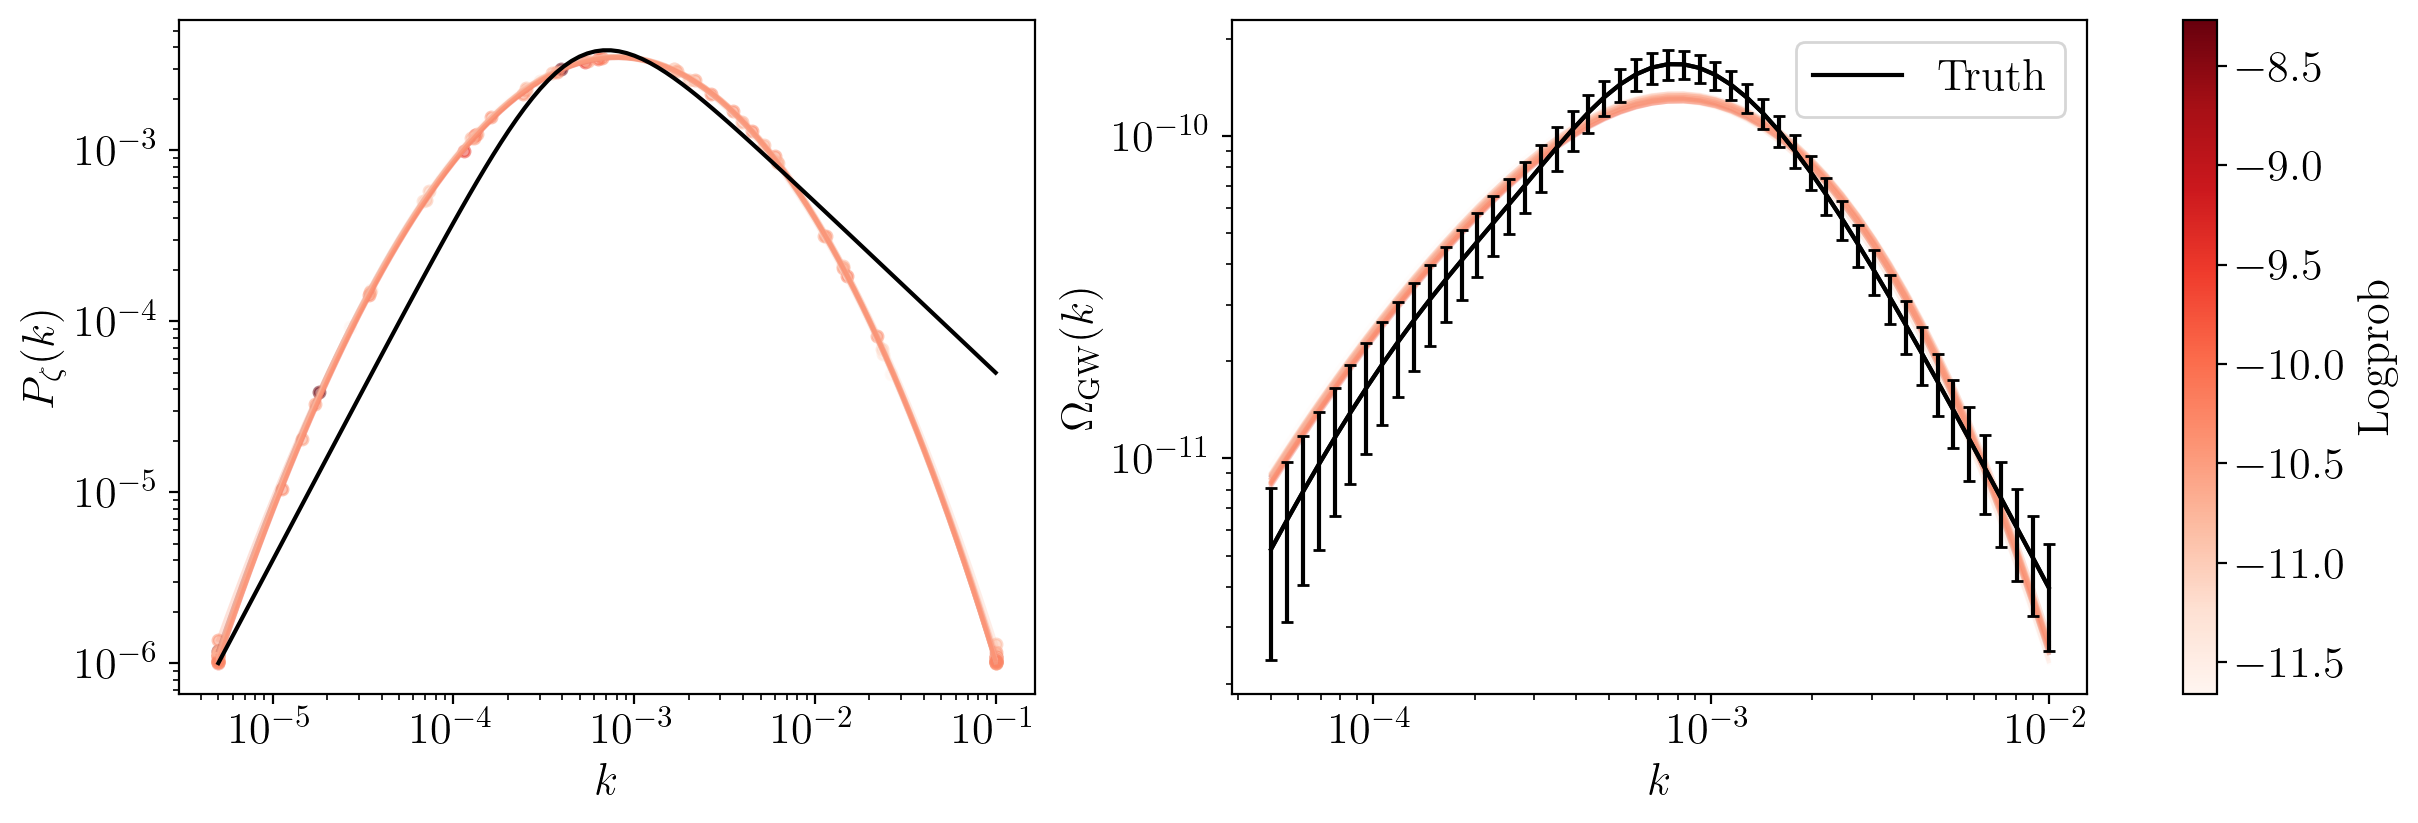

In [7]:
p_arr = np.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

ys = samples[:,free_nodes:]
xs = samples[:,:free_nodes]
print(len(samples))
thinning = len(samples) // 24
print(thinning)
cmap = matplotlib.colormaps['Reds']
ys = ys[::thinning]
xs = xs[::thinning]
lp = lp[::thinning] 
lp_min, lp_max = np.min(lp), np.max(lp)
print(lp_min, lp_max)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour

# print(cols)
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(x,y):
    pf = lambda k: interpolate(x, y , jnp.log10(k))
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,  frequencies)
    return pz_amps, gwb_res

for i,y in enumerate(ys):
    x = jnp.pad(xs[i], (1,1), 'constant', constant_values=(left_node, right_node) )
    pz_amps, gwb_amps = get_pz_omega(x,y)
    ax1.loglog(p_arr,pz_amps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(x),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
    ax2.loglog(frequencies,gwb_amps,alpha=0.25,color=cmap(cols[i]))

# pz_amp = test_pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)

ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')